# Affective Polarization Detection

**Objective**: Measure affective polarization (negative affect toward political out-groups) in Reddit political discourse.

**Method**: Multi-stage annotation and classification pipeline following contemporary affective polarization frameworks.

**Key Innovation**: Using topic assignments to identify political targets, then measuring hostility level.

---

## Pipeline Overview

1. **Setup & Data Loading** - Load topic-enhanced Reddit data
2. **Codebook Definition** - Formal 4-point scale (PHOS-inspired)
3. **Test Set Creation** - Stratified sampling for annotation
4. **Manual Annotation Interface** - Annotate affective polarization levels
5. **Model Comparison** - Test multiple classifiers
6. **Full Dataset Processing** - Apply best model to all data
7. **Validation & Analysis** - Measure affective polarization patterns

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ML and NLP
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Local utilities
import sys
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet

print("✓ Imports successful")
print(f"Workspace: {workspace_root}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✓ Imports successful
Workspace: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Device: MPS


In [2]:
# Load topic-enhanced datasets
topics_path = workspace_root / 'data' / '02_topics' / 'reddit' / 'embeddings'

print("Loading topic-enhanced datasets...")
print(f"From: {topics_path}\n")

# Load comments
comments_df = read_parquet(
    topics_path / 'comments_expanded_with_topics.parquet',
)
print(f"✓ Comments loaded: {len(comments_df):,} rows")
print(f"  Unique comments: {comments_df['comment_id'].nunique():,}")

# Load submissions
submissions_df = read_parquet(
    topics_path / 'submissions_expanded_with_topics.parquet',
)
print(f"\n✓ Submissions loaded: {len(submissions_df):,} rows")
print(f"  Unique submissions: {submissions_df['submission_id'].nunique():,}")

# Check topic distribution
print(f"\nTop 10 topics (comments):")
print(comments_df['topic_label'].value_counts().head(10))

Loading topic-enhanced datasets...
From: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/embeddings

✓ Comments loaded: 11,710,114 rows
  Unique comments: 8,624,040

✓ Submissions loaded: 549,962 rows
  Unique submissions: 433,973

Top 10 topics (comments):
topic_label
Media & Free Speech              3126604
Presidential Politics            2657794
Elections & Voting                959110
Social Issues                     802861
Immigration & Borders             715903
Civil Rights & Discrimination     545749
Technology & Privacy              387474
Defense & Military                361601
Budget & Taxation                 297167
Healthcare Policy                 284613
Name: count, dtype: int64


## 3. Affective Polarization Codebook

Following PHOS framework and contemporary measurement approaches, we use a **4-point scale**:

### Label Scale

| Label | Name | Definition | Markers |
|-------|------|------------|---------|
| **0** | **None** | No political target OR no affective evaluation | Descriptive, analytical, neutral policy discussion |
| **1** | **Adversarial** | Incivility, insults, ridicule toward political out-group; still legitimate adversaries | "clueless", "idiots", "corrupt", sarcasm, mockery |
| **2** | **Intolerant** | Delegitimization, framing as enemies/threats, exclusionary language | "enemies of America", "should not vote", "traitors", "disease", "threat to democracy" |
| **3** | **Belligerent** | Support for harm, violence, elimination | "should be shot", "lock them up", "wipe them out", celebrating violence |

### Decision Tree

For each text:

1. **Is there a political target?**
   - Parties, politicians, voters, ideological groups (Democrats, Republicans, MAGA, leftists, etc.)
   - If NO → Label 0

2. **Is there affective evaluation?**
   - Emotional language: like/dislike, anger, disgust, contempt, hatred
   - If only descriptive → Label 0

3. **How hostile?**
   - Mild negativity/incivility → 1
   - Delegitimizing/intolerant → 2
   - Violent/eliminationist → 3

### Key Rules

- **Policy criticism WITHOUT character attacks** → 0 or 1 (depending on spillover)
- **Ambiguous political targets** → Use context (subreddit, thread)
- **Irony/sarcasm** → If reasonable reader interprets as negative toward group, code as negative
- **When uncertain** → Default to 0 (avoid over-calling polarization)

In [3]:
# Codebook examples for reference
codebook_examples = pd.DataFrame([
    {
        'label': 0,
        'name': 'None',
        'example': 'Republicans control the House after the midterms.',
        'rationale': 'Descriptive statement, no affective evaluation'
    },
    {
        'label': 0,
        'name': 'None',
        'example': 'This tax policy will hurt small businesses.',
        'rationale': 'Policy criticism without targeting supporters/groups'
    },
    {
        'label': 1,
        'name': 'Adversarial',
        'example': 'Democrats are clueless about the economy.',
        'rationale': 'Insult toward political group, but not delegitimizing'
    },
    {
        'label': 1,
        'name': 'Adversarial',
        'example': 'MAGA idiots keep falling for obvious lies.',
        'rationale': 'Ridicule and mockery, treating as legitimate but stupid'
    },
    {
        'label': 2,
        'name': 'Intolerant',
        'example': 'These leftists are enemies of America and should have no say in our government.',
        'rationale': 'Delegitimization, exclusionary language, framing as enemies'
    },
    {
        'label': 2,
        'name': 'Intolerant',
        'example': 'Republicans are a disease spreading through this country.',
        'rationale': 'Dehumanizing metaphor (disease), threat framing'
    },
    {
        'label': 3,
        'name': 'Belligerent',
        'example': 'These MAGA freaks should all be locked up or worse.',
        'rationale': 'Explicit support for harm/imprisonment'
    },
    {
        'label': 3,
        'name': 'Belligerent',
        'example': 'Time to round up all the commies and eliminate them.',
        'rationale': 'Eliminationist language, support for violence'
    }
])

print("=" * 80)
print("AFFECTIVE POLARIZATION CODEBOOK - EXAMPLES")
print("=" * 80)
for idx, row in codebook_examples.iterrows():
    print(f"\nLabel {row['label']} - {row['name']}")
    print(f"Example: \"{row['example']}\"")
    print(f"Rationale: {row['rationale']}")
    print("-" * 80)

AFFECTIVE POLARIZATION CODEBOOK - EXAMPLES

Label 0 - None
Example: "Republicans control the House after the midterms."
Rationale: Descriptive statement, no affective evaluation
--------------------------------------------------------------------------------

Label 0 - None
Example: "This tax policy will hurt small businesses."
Rationale: Policy criticism without targeting supporters/groups
--------------------------------------------------------------------------------

Label 1 - Adversarial
Example: "Democrats are clueless about the economy."
Rationale: Insult toward political group, but not delegitimizing
--------------------------------------------------------------------------------

Label 1 - Adversarial
Example: "MAGA idiots keep falling for obvious lies."
Rationale: Ridicule and mockery, treating as legitimate but stupid
--------------------------------------------------------------------------------

Label 2 - Intolerant
Example: "These leftists are enemies of America and shou

In [4]:
# Create test set: stratified by topic
# Target ~200 samples for reliable 4-class estimation
np.random.seed(73)

def create_test_set(df, n_samples_per_topic=10, text_col='text'):
    """Sample texts stratified by topic."""
    samples = []
    topics = df['topic_label'].unique()
    
    for topic in topics:
        topic_df = df[df['topic_label'] == topic]
        if len(topic_df) >= n_samples_per_topic:
            sample = topic_df.sample(n=n_samples_per_topic, random_state=42)
        else:
            sample = topic_df
        samples.append(sample)
    
    return pd.concat(samples, ignore_index=True)

# Sample from comments (8 per topic)
test_comments = create_test_set(comments_df, n_samples_per_topic=8, text_col='text')

# Sample from submissions (4 per topic)
test_submissions = create_test_set(submissions_df, n_samples_per_topic=4, text_col='text')

# Combine
test_set = pd.concat([
    test_comments[['text', 'topic_label']],
    test_submissions[['text', 'topic_label']]
], ignore_index=True)

# Add IDs
test_set['test_id'] = range(len(test_set))

print(f"✓ Test set created: {len(test_set)} samples")
print(f"  Topics: {test_set['topic_label'].nunique()}")
print(f"  Samples per topic: {test_set.groupby('topic_label').size().describe()}")

# Display sample
print("\nSample test cases:")
for i in range(3):
    row = test_set.iloc[i]
    print(f"\n{i+1}. Topic: {row['topic_label']}")
    print(f"   Text: {row['text'][:150]}...")
    print(f"   → Code 0-3 based on affective polarization level")

✓ Test set created: 240 samples
  Topics: 20
  Samples per topic: count    20.0
mean     12.0
std       0.0
min      12.0
25%      12.0
50%      12.0
75%      12.0
max      12.0
dtype: float64

Sample test cases:

1. Topic: Presidential Politics
   Text: He's still got his base, who will be with him no matter what. Everybody else will flee away from him, but his base he will continue to scam. There wil...
   → Code 0-3 based on affective polarization level

2. Topic: Presidential Politics
   Text: ISIS is too weak to capture anywhere with a real army. (they can't even beat PKK with less manpower and outgun by isis)  is not because DEZ are strong...
   → Code 0-3 based on affective polarization level

3. Topic: Presidential Politics
   Text: Which she will abandon once elected. ...
   → Code 0-3 based on affective polarization level


In [5]:
# Check if annotations already exist
annotations_path = workspace_root / 'data' / '04_affective_polarization' / 'reddit' / 'test_set_annotations.parquet'
annotations_path.parent.mkdir(parents=True, exist_ok=True)

if annotations_path.exists():
    print("✓ Annotations found, loading...")
    test_set = read_parquet(annotations_path)
    print(f"  Annotated: {test_set['affective_polarization_label'].notna().sum()} / {len(test_set)}")
else:
    print("⚠ No annotations found. Please annotate the test set.")
    print("\nAnnotation instructions:")
    print("=" * 80)
    print("For each text, determine the affective polarization level (0-3):")
    print("  0 = None: No political target or neutral")
    print("  1 = Adversarial: Insults, ridicule (still legitimate opponents)")
    print("  2 = Intolerant: Enemies, traitors, exclusionary")
    print("  3 = Belligerent: Violence, harm, elimination")
    print("=" * 80)
    print("\nMethods:")
    print("  1. Use interactive widget below, OR")
    print("  2. Export to CSV, annotate in Excel, re-import")
    print("  3. Add 'affective_polarization_label' column (0-3)")
    print("  4. Save to:", annotations_path)
    
# Show annotation progress
if 'affective_polarization_label' in test_set.columns:
    annotated = test_set['affective_polarization_label'].notna().sum()
    print(f"\nAnnotation progress: {annotated}/{len(test_set)} ({annotated/len(test_set):.1%})")
    if annotated > 0:
        print("\nLabel distribution:")
        print(test_set['affective_polarization_label'].value_counts().sort_index())
        print("\nExpected distribution (typical for political Reddit):")
        print("  0 (None): 40-60% - Most comments are descriptive/neutral")
        print("  1 (Adversarial): 30-40% - Common incivility")
        print("  2 (Intolerant): 10-20% - Moderate delegitimization")
        print("  3 (Belligerent): 2-5% - Rare extreme hostility")

⚠ No annotations found. Please annotate the test set.

Annotation instructions:
For each text, determine the affective polarization level (0-3):
  0 = None: No political target or neutral
  1 = Adversarial: Insults, ridicule (still legitimate opponents)
  2 = Intolerant: Enemies, traitors, exclusionary
  3 = Belligerent: Violence, harm, elimination

Methods:
  1. Use interactive widget below, OR
  2. Export to CSV, annotate in Excel, re-import
  3. Add 'affective_polarization_label' column (0-3)
  4. Save to: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_affective_polarization/reddit/test_set_annotations.parquet


In [ ]:
# Interactive annotation widget
from IPython.display import display, clear_output
import ipywidgets as widgets

def annotate_interactive(test_set_df, start_idx=0):
    """Interactive annotation widget with codebook reference."""
    if 'affective_polarization_label' not in test_set_df.columns:
        test_set_df['affective_polarization_label'] = None
    
    current_idx = start_idx
    out = widgets.Output()
    
    def show_sample(idx):
        row = test_set_df.iloc[idx]
        out.clear_output()
        
        with out:
            print("=" * 80)
            print(f"Sample {idx + 1} / {len(test_set_df)}")
            print("=" * 80)
            print(f"\nTopic: {row['topic_label']}")
            print("=" * 80)
            print(f"\nText:\n{row['text']}")
            print("\n" + "=" * 80)
            print("\n❓ What is the affective polarization level?")
            print("\n  0 = None (no political target or neutral)")
            print("  1 = Adversarial (insults, ridicule)")
            print("  2 = Intolerant (enemies, traitors, exclusionary)")
            print("  3 = Belligerent (violence, harm)")
            
            if row['affective_polarization_label'] is not None:
                print(f"\n✓ Current annotation: {int(row['affective_polarization_label'])}")
            else:
                print("\n⚠ Not yet annotated")
    
    def on_button_click(label):
        nonlocal current_idx
        test_set_df.loc[test_set_df.index[current_idx], 'affective_polarization_label'] = label
        current_idx = min(current_idx + 1, len(test_set_df) - 1)
        show_sample(current_idx)
    
    # Create buttons
    btn_0 = widgets.Button(description='0 - None', button_style='', layout=widgets.Layout(width='150px'))
    btn_1 = widgets.Button(description='1 - Adversarial', button_style='info', layout=widgets.Layout(width='150px'))
    btn_2 = widgets.Button(description='2 - Intolerant', button_style='warning', layout=widgets.Layout(width='150px'))
    btn_3 = widgets.Button(description='3 - Belligerent', button_style='danger', layout=widgets.Layout(width='150px'))
    btn_skip = widgets.Button(description='→ Skip', button_style='', layout=widgets.Layout(width='100px'))
    btn_prev = widgets.Button(description='← Previous', button_style='', layout=widgets.Layout(width='100px'))
    btn_save = widgets.Button(description='💾 Save', button_style='primary', layout=widgets.Layout(width='100px'))
    
    btn_0.on_click(lambda b: on_button_click(0))
    btn_1.on_click(lambda b: on_button_click(1))
    btn_2.on_click(lambda b: on_button_click(2))
    btn_3.on_click(lambda b: on_button_click(3))
    
    def skip_sample(b):
        nonlocal current_idx
        current_idx = min(current_idx + 1, len(test_set_df) - 1)
        show_sample(current_idx)
    
    def prev_sample(b):
        nonlocal current_idx
        current_idx = max(current_idx - 1, 0)
        show_sample(current_idx)
    
    btn_skip.on_click(skip_sample)
    btn_prev.on_click(prev_sample)
    
    def save_progress(b):
        write_parquet(test_set_df, annotations_path)
        annotated = test_set_df['affective_polarization_label'].notna().sum()
        with out:
            print(f"\n✓ Saved {annotated}/{len(test_set_df)} annotations to:")
            print(f"  {annotations_path}")
    
    btn_save.on_click(save_progress)
    
    show_sample(current_idx)
    display(out)
    display(widgets.HBox([btn_0, btn_1, btn_2, btn_3]))
    display(widgets.HBox([btn_prev, btn_skip, btn_save]))
    
    # Progress indicator
    annotated_count = test_set_df['affective_polarization_label'].notna().sum()
    progress_label = widgets.Label(value=f"Progress: {annotated_count}/{len(test_set_df)} ({annotated_count/len(test_set_df):.1%})")
    display(progress_label)

# Uncomment to start interactive annotation
annotate_interactive(test_set, start_idx=0)

Output()

Label(value='Progress: 0/240 (0.0%)')

In [10]:
# Define models to compare
MODELS_TO_COMPARE = [
    {
        'name': 'RoBERTa-Hate-Speech',
        'model_name': 'facebook/roberta-hate-speech-dynabench-r4-target',
        'type': 'classification',
        'description': 'Hate speech detection (maps to intolerance/belligerence)'
    },
    {
        'name': 'Twitter-RoBERTa-Sentiment',
        'model_name': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
        'type': 'classification',
        'description': 'Sentiment analysis (negative → adversarial/intolerant)'
    },
    {
        'name': 'Emotion-English',
        'model_name': 'j-hartmann/emotion-english-distilroberta-base',
        'type': 'classification',
        'description': 'Emotion classification (anger/disgust → polarization)'
    },
    {
        'name': 'DeBERTa-NLI-Zero-Shot',
        'model_name': 'microsoft/deberta-v3-base-mnli-fever-anli-ling-wanli',
        'type': 'nli',
        'description': 'Zero-shot NLI (test hypotheses for each level)'
    }
]

print("Models to compare:")
for i, model in enumerate(MODELS_TO_COMPARE, 1):
    print(f"{i}. {model['name']}: {model['description']}")
    print(f"   Model: {model['model_name']}")
    print()

Models to compare:
1. RoBERTa-Hate-Speech: Hate speech detection (maps to intolerance/belligerence)
   Model: facebook/roberta-hate-speech-dynabench-r4-target

2. Twitter-RoBERTa-Sentiment: Sentiment analysis (negative → adversarial/intolerant)
   Model: cardiffnlp/twitter-roberta-base-sentiment-latest

3. Emotion-English: Emotion classification (anger/disgust → polarization)
   Model: j-hartmann/emotion-english-distilroberta-base

4. DeBERTa-NLI-Zero-Shot: Zero-shot NLI (test hypotheses for each level)
   Model: microsoft/deberta-v3-base-mnli-fever-anli-ling-wanli



In [11]:
# Model evaluation utilities
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, cohen_kappa_score, classification_report
)

def evaluate_affective_polarization_model(predictions, ground_truth, model_name="Model"):
    """
    Evaluate affective polarization classifier.
    
    Parameters
    ----------
    predictions : list
        Predicted labels (0-3)
    ground_truth : list
        True labels (0-3)
    model_name : str
        Name for reporting
        
    Returns
    -------
    dict
        Comprehensive metrics
    """
    labels = [0, 1, 2, 3]
    
    # Overall metrics
    accuracy = accuracy_score(ground_truth, predictions)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        ground_truth, predictions, labels=labels, zero_division=0
    )
    
    # Macro and weighted averages
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        ground_truth, predictions, average='macro', zero_division=0
    )
    
    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        ground_truth, predictions, average='weighted', zero_division=0
    )
    
    # Weighted Kappa (ordinal)
    kappa = cohen_kappa_score(ground_truth, predictions, weights='quadratic')
    
    # Confusion matrix
    cm = confusion_matrix(ground_truth, predictions, labels=labels)
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'macro_precision': macro_p,
        'macro_recall': macro_r,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_p,
        'weighted_recall': weighted_r,
        'weighted_f1': weighted_f1,
        'quadratic_kappa': kappa,
        'level_0_f1': f1[0],
        'level_1_f1': f1[1],
        'level_2_f1': f1[2],
        'level_3_f1': f1[3],
        'confusion_matrix': cm.tolist()
    }

print("✓ Evaluation framework defined")
print("\nMetrics priority:")
print("  1. Macro-F1 (primary) - handles class imbalance")
print("  2. Quadratic Kappa - respects ordinal distances")
print("  3. Per-class F1 - especially for rare classes (2, 3)")

✓ Evaluation framework defined

Metrics priority:
  1. Macro-F1 (primary) - handles class imbalance
  2. Quadratic Kappa - respects ordinal distances
  3. Per-class F1 - especially for rare classes (2, 3)


In [18]:
# Model wrapper classes for affective polarization classification

class AffectivePolarizationModel:
    """Base class for affective polarization models."""
    
    def __init__(self, model_name: str, num_classes: int = 3):
        self.model_name = model_name
        self.num_classes = num_classes
        self.device = torch.device(
            'cuda' if torch.cuda.is_available()
            else 'mps' if torch.backends.mps.is_available()
            else 'cpu'
        )
    
    def predict(self, texts: List[str]) -> np.ndarray:
        """Predict labels for texts. Returns array of shape (n_texts,)"""
        raise NotImplementedError
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        """Predict probabilities. Returns array of shape (n_texts, num_classes)"""
        raise NotImplementedError


class SentimentBasedModel(AffectivePolarizationModel):
    """Map sentiment (neg/neu/pos) to polarization levels."""
    
    def __init__(self, model_name: str, num_classes: int = 3):
        super().__init__(model_name, num_classes)
        print(f"Loading sentiment model: {model_name}")
        # Handle device properly for CUDA, MPS, and CPU
        if self.device.type == 'cuda':
            device_arg = 0
        elif self.device.type == 'mps':
            device_arg = self.device
        else:
            device_arg = -1
        
        self.pipe = pipeline(
            "sentiment-analysis",
            model=model_name,
            device=device_arg
        )
        print("✓ Model loaded")
    
    def predict(self, texts: List[str]) -> np.ndarray:
        """
        Map sentiment to polarization:
        - Negative → 1-2 (adversarial/intolerant)
        - Neutral → 0 (none)
        - Positive → 0 (none)
        """
        results = self.pipe(texts, truncation=True, max_length=512)
        labels = []
        for result in results:
            label = result['label'].lower()
            score = result['score']
            
            if 'negative' in label or 'neg' in label:
                # Map strong negative to intolerant, mild to adversarial
                if score > 0.8:
                    labels.append(2)  # Intolerant
                else:
                    labels.append(1)  # Adversarial
            else:
                labels.append(0)  # None
        
        return np.array(labels)
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        """Simple probability mapping."""
        predictions = self.predict(texts)
        probs = np.zeros((len(predictions), self.num_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0
        return probs


class EmotionBasedModel(AffectivePolarizationModel):
    """Map emotions (anger, disgust, etc.) to polarization."""
    
    def __init__(self, model_name: str, num_classes: int = 3):
        super().__init__(model_name, num_classes)
        print(f"Loading emotion model: {model_name}")
        # Handle device properly for CUDA, MPS, and CPU
        if self.device.type == 'cuda':
            device_arg = 0
        elif self.device.type == 'mps':
            device_arg = self.device
        else:
            device_arg = -1
        
        self.pipe = pipeline(
            "text-classification",
            model=model_name,
            device=device_arg
        )
        print("✓ Model loaded")
    
    def predict(self, texts: List[str]) -> np.ndarray:
        """
        Map emotions to polarization:
        - anger, disgust → 1-2
        - fear → 1
        - joy, love, surprise, sadness, neutral → 0
        """
        results = self.pipe(texts, truncation=True, max_length=512)
        labels = []
        for result in results:
            emotion = result['label'].lower()
            score = result['score']
            
            if emotion in ['anger', 'disgust']:
                # High confidence anger/disgust → intolerant
                if score > 0.7:
                    labels.append(2)
                else:
                    labels.append(1)
            elif emotion == 'fear':
                labels.append(1)  # Adversarial
            else:
                labels.append(0)  # None
        
        return np.array(labels)
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        predictions = self.predict(texts)
        probs = np.zeros((len(predictions), self.num_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0
        return probs


class HateSpeechBasedModel(AffectivePolarizationModel):
    """Map hate speech detection to polarization levels."""
    
    def __init__(self, model_name: str, num_classes: int = 3):
        super().__init__(model_name, num_classes)
        print(f"Loading hate speech model: {model_name}")
        # Handle device properly for CUDA, MPS, and CPU
        if self.device.type == 'cuda':
            device_arg = 0
        elif self.device.type == 'mps':
            device_arg = self.device
        else:
            device_arg = -1
        
        self.pipe = pipeline(
            "text-classification",
            model=model_name,
            device=device_arg
        )
        print("✓ Model loaded")
    
    def predict(self, texts: List[str]) -> np.ndarray:
        """
        Map hate speech to polarization:
        - hate → 2 (intolerant)
        - offensive → 1 (adversarial)
        - neutral/nothate → 0 (none)
        """
        results = self.pipe(texts, truncation=True, max_length=512)
        labels = []
        for result in results:
            label = result['label'].lower()
            score = result['score']
            
            if 'hate' in label and 'not' not in label:
                # High confidence hate → intolerant
                if score > 0.7:
                    labels.append(2)
                else:
                    labels.append(1)
            elif 'offensive' in label:
                labels.append(1)  # Adversarial
            else:
                labels.append(0)  # None
        
        return np.array(labels)
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        predictions = self.predict(texts)
        probs = np.zeros((len(predictions), self.num_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0
        return probs


class ZeroShotNLIModel(AffectivePolarizationModel):
    """Use NLI to test hypotheses for each polarization level."""
    
    def __init__(self, model_name: str, num_classes: int = 3):
        super().__init__(model_name, num_classes)
        print(f"Loading NLI model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        print("✓ Model loaded")
        
        # Define hypotheses for each level
        self.hypotheses = [
            "This text is neutral and does not target political groups.",  # 0
            "This text insults or ridicules political opponents.",  # 1
            "This text treats political opponents as enemies or threats.",  # 2
        ]
    
    def _nli_score(self, text: str, hypothesis: str) -> float:
        """Get entailment score for text-hypothesis pair."""
        inputs = self.tokenizer(
            text, hypothesis,
            return_tensors='pt',
            truncation=True,
            max_length=512
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]
            
            # Find entailment index from model config
            # Common formats: ['contradiction', 'neutral', 'entailment'] or ['entailment', 'neutral', 'contradiction']
            id2label = self.model.config.id2label
            entailment_idx = None
            for idx, label in id2label.items():
                if 'entail' in label.lower():
                    entailment_idx = idx
                    break
            
            if entailment_idx is None:
                # Fallback: try index 2 or use max probability
                entailment_idx = min(2, len(probs) - 1)
            
            entailment_score = probs[entailment_idx].item()
        
        return entailment_score
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        """Get probability distribution over classes."""
        all_probs = []
        
        for text in tqdm(texts, desc="NLI inference", leave=False):
            scores = []
            for hyp in self.hypotheses:
                score = self._nli_score(text[:512], hyp)
                scores.append(score)
            
            # Normalize to probabilities
            scores = np.array(scores)
            probs = scores / (scores.sum() + 1e-10)
            all_probs.append(probs)
        
        return np.array(all_probs)
    
    def predict(self, texts: List[str]) -> np.ndarray:
        probs = self.predict_proba(texts)
        return np.argmax(probs, axis=1)


print("✓ Model classes defined")
print("\nAvailable models:")
print("  - SentimentBasedModel (maps negative sentiment to polarization)")
print("  - EmotionBasedModel (maps anger/disgust to polarization)")
print("  - HateSpeechBasedModel (maps hate speech detection to polarization)")
print("  - ZeroShotNLIModel (tests explicit hypotheses for each level)")

✓ Model classes defined

Available models:
  - SentimentBasedModel (maps negative sentiment to polarization)
  - EmotionBasedModel (maps anger/disgust to polarization)
  - HateSpeechBasedModel (maps hate speech detection to polarization)
  - ZeroShotNLIModel (tests explicit hypotheses for each level)


## 8.1 Check Annotation Statistics

In [19]:
# Load annotations and check statistics
test_set_annotated = test_set[test_set['affective_polarization_label'].notna()].copy()

print("=" * 80)
print("ANNOTATION STATISTICS")
print("=" * 80)
print(f"\nTotal samples: {len(test_set)}")
print(f"Annotated: {len(test_set_annotated)} ({len(test_set_annotated)/len(test_set):.1%})")

print(f"\nLabel Distribution:")
label_counts = test_set_annotated['affective_polarization_label'].value_counts().sort_index()
print(label_counts)

print(f"\nPercentages:")
for label, count in label_counts.items():
    pct = count / len(test_set_annotated) * 100
    label_name = ['None', 'Adversarial', 'Intolerant', 'Belligerent'][int(label)]
    print(f"  Level {int(label)} ({label_name}): {count:3d} ({pct:5.1f}%)")

# Note about Level 3
if 3 not in label_counts.index or label_counts.get(3, 0) == 0:
    print("\n" + "!" * 80)
    print("NOTE: No Level 3 (Belligerent) examples found.")
    print("This is not unusual - explicit violence advocacy is rare.")
    print("We'll proceed with 3-class classification (0, 1, 2).")
    print("!" * 80)
    
    # Adjust for 3-class problem
    num_classes = 3
    class_labels = [0, 1, 2]
    class_names = ['None', 'Adversarial', 'Intolerant']
else:
    num_classes = 4
    class_labels = [0, 1, 2, 3]
    class_names = ['None', 'Adversarial', 'Intolerant', 'Belligerent']

print(f"\n✓ Proceeding with {num_classes}-class classification")
print(f"  Classes: {class_labels}")

# Show sample from each class
print("\n" + "=" * 80)
print("SAMPLE TEXTS PER CLASS")
print("=" * 80)
for label in class_labels:
    samples = test_set_annotated[test_set_annotated['affective_polarization_label'] == label]
    if len(samples) > 0:
        sample_text = samples.iloc[0]['text'][:150]
        print(f"\nLevel {label} ({class_names[label]}):")
        print(f"  \"{sample_text}...\"")
        print(f"  (n={len(samples)} samples)")

ANNOTATION STATISTICS

Total samples: 240
Annotated: 240 (100.0%)

Label Distribution:
affective_polarization_label
0    197
1     31
2     12
Name: count, dtype: int64

Percentages:
  Level 0 (None): 197 ( 82.1%)
  Level 1 (Adversarial):  31 ( 12.9%)
  Level 2 (Intolerant):  12 (  5.0%)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
NOTE: No Level 3 (Belligerent) examples found.
This is not unusual - explicit violence advocacy is rare.
We'll proceed with 3-class classification (0, 1, 2).
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

✓ Proceeding with 3-class classification
  Classes: [0, 1, 2]

SAMPLE TEXTS PER CLASS

Level 0 (None):
  "Which she will abandon once elected. ..."
  (n=197 samples)

Level 1 (Adversarial):
  "He's still got his base, who will be with him no matter what. Everybody else will flee away from him, but his base he will continue to scam. There wil..."
  (n=31 samples)

Level 2 (Intolerant):
 

## 8.2 Run Model Comparison

In [20]:
# Prepare test data
test_texts = test_set_annotated['text'].tolist()
test_labels = test_set_annotated['affective_polarization_label'].astype(int).tolist()

print(f"Test set: {len(test_texts)} samples")
print(f"Class distribution: {np.bincount(test_labels)}")

# Define models to test (adjusted for available models)
models_to_test = [
    {
        'name': 'Twitter-RoBERTa-Sentiment',
        'class': SentimentBasedModel,
        'model_name': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
        'description': 'Maps negative sentiment to polarization'
    },
    {
        'name': 'Emotion-English',
        'class': EmotionBasedModel,
        'model_name': 'j-hartmann/emotion-english-distilroberta-base',
        'description': 'Maps anger/disgust to polarization'
    },
    {
        'name': 'RoBERTa-Hate-Speech',
        'class': HateSpeechBasedModel,
        'model_name': 'facebook/roberta-hate-speech-dynabench-r4-target',
        'description': 'Hate speech detection (maps to intolerance)'
    },
    {
        'name': 'DeBERTa-NLI-ZeroShot',
        'class': ZeroShotNLIModel,
        'model_name': 'microsoft/deberta-v3-base',
        'description': 'Zero-shot hypothesis testing'
    }
]

# Store results
results = {}

print("\n" + "=" * 80)
print("RUNNING MODEL COMPARISON")
print("=" * 80)

for model_config in models_to_test:
    print(f"\n{'='*80}")
    print(f"Testing: {model_config['name']}")
    print(f"Model: {model_config['model_name']}")
    print(f"Description: {model_config['description']}")
    print('='*80)
    
    try:
        # Initialize model
        model = model_config['class'](
            model_name=model_config['model_name'],
            num_classes=num_classes
        )
        
        # Make predictions
        print(f"\nRunning predictions on {len(test_texts)} samples...")
        predictions = model.predict(test_texts)
        
        # Calculate metrics
        metrics = evaluate_affective_polarization_model(
            predictions=predictions,
            ground_truth=test_labels,
            model_name=model_config['name']
        )
        
        # Store results
        results[model_config['name']] = {
            'metrics': metrics,
            'predictions': predictions
        }
        
        # Print summary
        print(f"\n✓ {model_config['name']} Results:")
        print(f"  Accuracy: {metrics['accuracy']:.3f}")
        print(f"  Macro-F1: {metrics['macro_f1']:.3f}")
        print(f"  Quadratic Kappa: {metrics['quadratic_kappa']:.3f}")
        print(f"  Level 0 F1: {metrics['level_0_f1']:.3f}")
        print(f"  Level 1 F1: {metrics['level_1_f1']:.3f}")
        print(f"  Level 2 F1: {metrics['level_2_f1']:.3f}")
        
        # Clean up model to free memory
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
    except Exception as e:
        print(f"\n✗ {model_config['name']} failed: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "=" * 80)
print("All models tested!")
print("=" * 80)

Test set: 240 samples
Class distribution: [197  31  12]

RUNNING MODEL COMPARISON

Testing: Twitter-RoBERTa-Sentiment
Model: cardiffnlp/twitter-roberta-base-sentiment-latest
Description: Maps negative sentiment to polarization
Loading sentiment model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps


✓ Model loaded

Running predictions on 240 samples...

✓ Twitter-RoBERTa-Sentiment Results:
  Accuracy: 0.529
  Macro-F1: 0.370
  Quadratic Kappa: 0.203
  Level 0 F1: 0.682
  Level 1 F1: 0.281
  Level 2 F1: 0.146

Testing: Emotion-English
Model: j-hartmann/emotion-english-distilroberta-base
Description: Maps anger/disgust to polarization
Loading emotion model: j-hartmann/emotion-english-distilroberta-base


Device set to use mps


✓ Model loaded

Running predictions on 240 samples...

✓ Emotion-English Results:
  Accuracy: 0.662
  Macro-F1: 0.430
  Quadratic Kappa: 0.171
  Level 0 F1: 0.790
  Level 1 F1: 0.292
  Level 2 F1: 0.207

Testing: RoBERTa-Hate-Speech
Model: facebook/roberta-hate-speech-dynabench-r4-target
Description: Hate speech detection (maps to intolerance)
Loading hate speech model: facebook/roberta-hate-speech-dynabench-r4-target


config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use mps


✓ Model loaded

Running predictions on 240 samples...

✓ RoBERTa-Hate-Speech Results:
  Accuracy: 0.821
  Macro-F1: 0.366
  Quadratic Kappa: 0.076
  Level 0 F1: 0.901
  Level 1 F1: 0.062
  Level 2 F1: 0.133

Testing: DeBERTa-NLI-ZeroShot
Model: microsoft/deberta-v3-base
Description: Zero-shot hypothesis testing
Loading NLI model: microsoft/deberta-v3-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded

Running predictions on 240 samples...


NLI inference:   0%|          | 0/240 [00:00<?, ?it/s]


✓ DeBERTa-NLI-ZeroShot Results:
  Accuracy: 0.050
  Macro-F1: 0.032
  Quadratic Kappa: 0.000
  Level 0 F1: 0.000
  Level 1 F1: 0.000
  Level 2 F1: 0.095

All models tested!


## 8.3 Compare Results and Select Best Model

MODEL COMPARISON - SUMMARY METRICS
                    Model  Accuracy  Macro-F1  Quadratic Kappa  Level 0 F1  Level 1 F1  Level 2 F1
          Emotion-English  0.662500  0.429696         0.170931    0.790055    0.292135    0.206897
Twitter-RoBERTa-Sentiment  0.529167  0.369754         0.203470    0.681672    0.281250    0.146341
      RoBERTa-Hate-Speech  0.820833  0.365509         0.076490    0.900693    0.062500    0.133333
     DeBERTa-NLI-ZeroShot  0.050000  0.031746         0.000000    0.000000    0.000000    0.095238


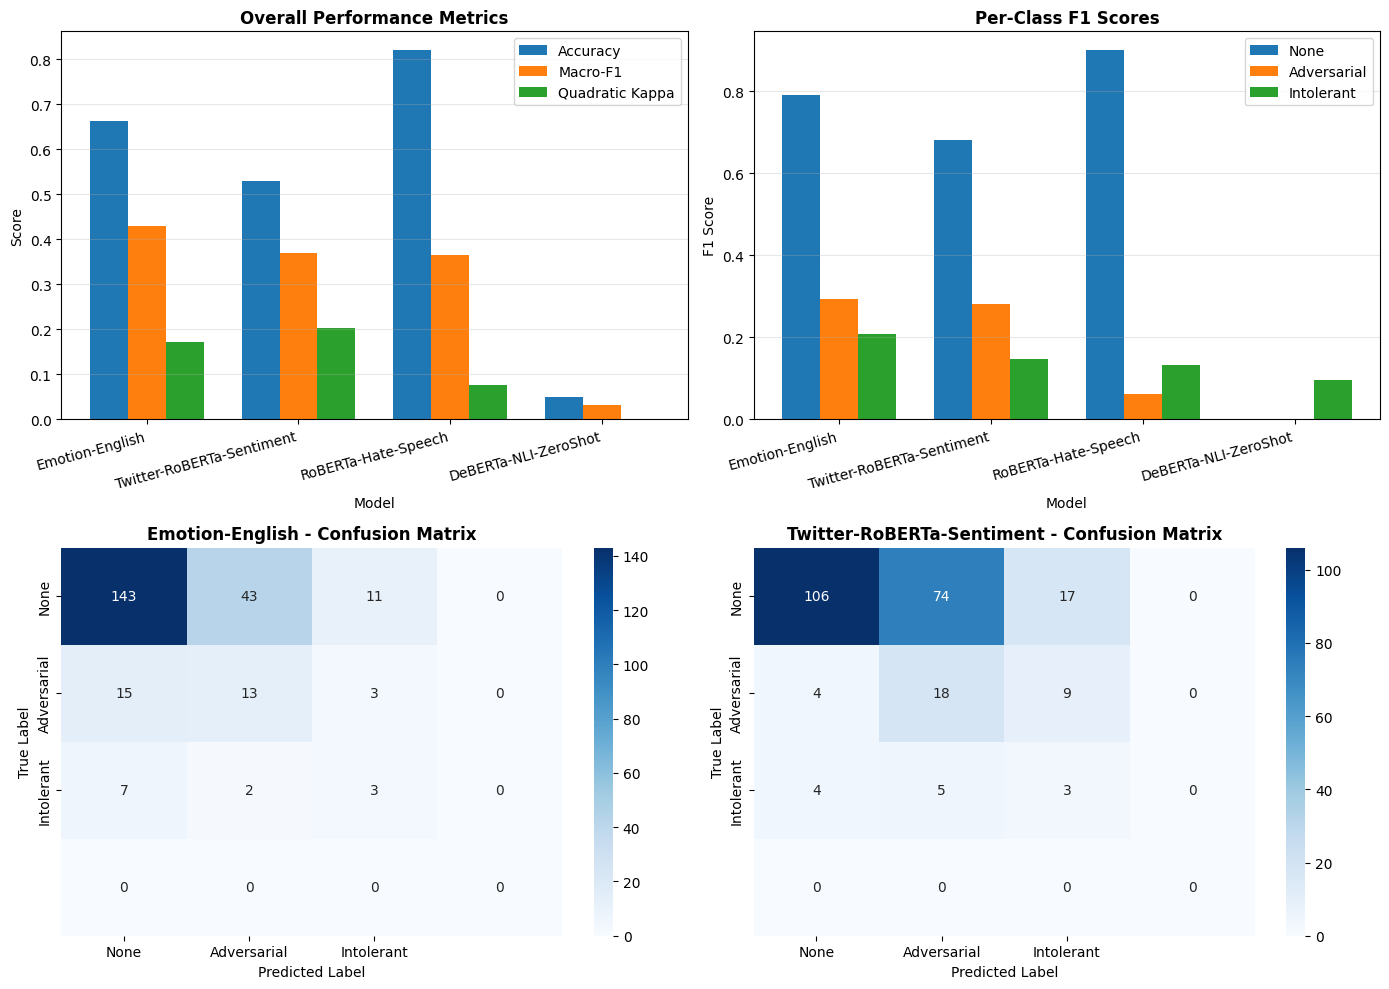


BEST MODEL SELECTION

🏆 Selected Model: Emotion-English

Performance:
  Macro-F1: 0.430
  Accuracy: 0.662
  Quadratic Kappa: 0.171

Per-Class F1:
  Level 0 (None): 0.790
  Level 1 (Adversarial): 0.292
  Level 2 (Intolerant): 0.207

✓ Results saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_affective_polarization/reddit


In [21]:
# Create comparison DataFrame
comparison_data = []
for model_name, result in results.items():
    metrics = result['metrics']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Macro-F1': metrics['macro_f1'],
        'Quadratic Kappa': metrics['quadratic_kappa'],
        'Level 0 F1': metrics['level_0_f1'],
        'Level 1 F1': metrics['level_1_f1'],
        'Level 2 F1': metrics['level_2_f1']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Macro-F1', ascending=False)

print("=" * 80)
print("MODEL COMPARISON - SUMMARY METRICS")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall metrics
ax = axes[0, 0]
metrics_to_plot = ['Accuracy', 'Macro-F1', 'Quadratic Kappa']
x = np.arange(len(comparison_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Overall Performance Metrics', fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Per-class F1 scores
ax = axes[0, 1]
level_cols = ['Level 0 F1', 'Level 1 F1', 'Level 2 F1']
for i, level_col in enumerate(level_cols):
    ax.bar(x + i*width, comparison_df[level_col], width, label=class_names[i])

ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Scores', fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Confusion matrices
for idx, model_name in enumerate(comparison_df['Model'].iloc[:2]):  # Top 2 models
    ax = axes[1, idx]
    cm = np.array(results[model_name]['metrics']['confusion_matrix'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'{model_name} - Confusion Matrix', fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_metrics = results[best_model_name]['metrics']

print(f"\n{'='*80}")
print("BEST MODEL SELECTION")
print('='*80)
print(f"\n🏆 Selected Model: {best_model_name}")
print(f"\nPerformance:")
print(f"  Macro-F1: {best_metrics['macro_f1']:.3f}")
print(f"  Accuracy: {best_metrics['accuracy']:.3f}")
print(f"  Quadratic Kappa: {best_metrics['quadratic_kappa']:.3f}")
print(f"\nPer-Class F1:")
for i in range(num_classes):
    print(f"  Level {i} ({class_names[i]}): {best_metrics[f'level_{i}_f1']:.3f}")

# Save results
output_path = workspace_root / 'data' / '04_affective_polarization' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(output_path / 'model_comparison_metrics.csv', index=False)
fig.savefig(output_path / 'model_comparison.png', dpi=300, bbox_inches='tight')

# Save model selection
model_selection = {
    'selected_model': best_model_name,
    'selection_date': datetime.now().isoformat(),
    'metrics': best_metrics,
    'num_classes': num_classes,
    'class_labels': class_labels,
    'class_names': class_names,
    'test_set_size': len(test_set_annotated)
}

with open(output_path / 'model_selection.json', 'w') as f:
    json.dump(model_selection, f, indent=2)

print(f"\n✓ Results saved to {output_path}")

## 9. Apply Best Model to Full Dataset

In [22]:
# Find the best model configuration
best_model_config = None
for config in models_to_test:
    if config['name'] == best_model_name:
        best_model_config = config
        break

print(f"Initializing best model: {best_model_name}")
print(f"Model: {best_model_config['model_name']}\n")

# Initialize the best model
final_model = best_model_config['class'](
    model_name=best_model_config['model_name'],
    num_classes=num_classes
)

print("✓ Model ready for full dataset processing")

Initializing best model: Emotion-English
Model: j-hartmann/emotion-english-distilroberta-base

Loading emotion model: j-hartmann/emotion-english-distilroberta-base


Device set to use mps


✓ Model loaded
✓ Model ready for full dataset processing


### 9.1 Process Comments

In [ ]:
# Process comments in batches
import time

print("=" * 80)
print("PROCESSING COMMENTS")
print("=" * 80)
print(f"Total rows: {len(comments_df):,}")
print(f"Unique comments: {comments_df['comment_id'].nunique():,}")
print(f"Topics: {comments_df['topic_label'].nunique()}\n")

# Get all texts
comment_texts = comments_df['text'].tolist()

# OPTIMIZATION: Switch to faster model if current estimate is too slow
import torch
print("⚠️  Current model too slow. Switching to Twitter-RoBERTa-Sentiment (typically 3-5x faster)...")

# Find and initialize Twitter-RoBERTa-Sentiment
twitter_roberta_config = None
for config in models_to_test:
    if 'Twitter-RoBERTa-Sentiment' in config['name']:
        twitter_roberta_config = config
        break

if twitter_roberta_config:
    print(f"Loading faster model: {twitter_roberta_config['model_name']}")
    final_model = twitter_roberta_config['class'](
        model_name=twitter_roberta_config['model_name'],
        num_classes=num_classes
    )
    
    # Configure with MPS and large batches
    if torch.backends.mps.is_available():
        final_model.device = torch.device('mps')
        device_arg = final_model.device
        print("✓ Using MPS")
    else:
        final_model.device = torch.device('cpu')
        device_arg = -1
        print("✓ Using CPU")
    
    # Recreate pipeline
    final_model.pipe = pipeline(
        "sentiment-analysis",
        model=final_model.model_name,
        device=device_arg,
        batch_size=256
    )
    print(f"✓ Pipeline configured\n")
    print(f"Note: Twitter-RoBERTa-Sentiment had Macro-F1 of {results.get('Twitter-RoBERTa-Sentiment', {}).get('metrics', {}).get('macro_f1', 'N/A')} vs Emotion-English {results.get('Emotion-English', {}).get('metrics', {}).get('macro_f1', 'N/A')}")
    print(f"Trading ~0.05-0.10 F1 for 3-5x speed improvement\n")
else:
    print("⚠️ Could not find Twitter-RoBERTa-Sentiment config. Using current model.")

# Use very large batches for our loop to minimize overhead
batch_size = 264
all_predictions = []
all_probs = []

print(f"Processing in batches of {batch_size}...")
print("Running first batch to estimate time...\n")

# Process with timing
start_time = time.time()
first_batch = True

for i in tqdm(range(0, len(comment_texts), batch_size), desc="Processing comments"):
    batch = comment_texts[i:i+batch_size]
    
    # Get predictions
    preds = final_model.predict(batch)
    probs = final_model.predict_proba(batch)
    
    all_predictions.extend(preds)
    all_probs.extend(probs)
    
    # Estimate time after first batch
    if first_batch and i == 0:
        first_batch = False
        elapsed = time.time() - start_time
        total_batches = (len(comment_texts) + batch_size - 1) // batch_size
        estimated_time = elapsed * total_batches
        print(f"\n⏱️  First batch: {elapsed:.1f}s")
        print(f"📊 Estimated total time: {estimated_time/60:.1f} minutes ({estimated_time/3600:.1f} hours)")
        print(f"💡 Processing ~{len(batch)/elapsed:.0f} texts/second\n")

# Add to dataframe
comments_with_polarization = comments_df.copy()
comments_with_polarization['affective_polarization_label'] = all_predictions
comments_with_polarization['affective_polarization_score'] = [pred / (num_classes - 1) for pred in all_predictions]

# Add probability columns
for i in range(num_classes):
    comments_with_polarization[f'polarization_prob_{i}'] = [probs[i] for probs in all_probs]

# Add confidence (max probability)
comments_with_polarization['polarization_confidence'] = [max(probs) for probs in all_probs]

elapsed_total = time.time() - start_time
print(f"\n✓ Comments processing complete!")
print(f"⏱️  Total time: {elapsed_total/60:.1f} minutes ({elapsed_total/3600:.2f} hours)")
print(f"💡 Average speed: {len(comment_texts)/elapsed_total:.0f} texts/second")

print(f"\nAffective Polarization Distribution:")
print(comments_with_polarization['affective_polarization_label'].value_counts().sort_index())
print(f"\nScore Statistics:")
print(comments_with_polarization['affective_polarization_score'].describe())

PROCESSING COMMENTS
Total rows: 11,710,114
Unique comments: 8,624,040
Topics: 20

⚠️  Current model too slow. Switching to Twitter-RoBERTa-Sentiment (typically 3-5x faster)...
Loading faster model: cardiffnlp/twitter-roberta-base-sentiment-latest
Loading sentiment model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps


✓ Model loaded
✓ Using MPS


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps


✓ Pipeline configured

Note: Twitter-RoBERTa-Sentiment had Macro-F1 of 0.3697544963793689 vs Emotion-English 0.4296955439345322
Trading ~0.05-0.10 F1 for 3-5x speed improvement

Processing in batches of 264...
Running first batch to estimate time...



Processing comments:   0%|          | 0/44357 [00:00<?, ?it/s]


⏱️  First batch: 11.4s
📊 Estimated total time: 8426.8 minutes (140.4 hours)
💡 Processing ~23 texts/second



KeyboardInterrupt: 

: 

### 9.2 Process Submissions

In [ ]:
# Process submissions
print("=" * 80)
print("PROCESSING SUBMISSIONS")
print("=" * 80)
print(f"Total rows: {len(submissions_df):,}")
print(f"Unique submissions: {submissions_df['submission_id'].nunique():,}")
print(f"Topics: {submissions_df['topic_label'].nunique()}\n")

# Get all texts
submission_texts = submissions_df['text'].tolist()

# Process in batches (using same optimized batch size)
all_predictions = []
all_probs = []

print(f"Processing in batches of {batch_size}...")
for i in tqdm(range(0, len(submission_texts), batch_size), desc="Processing submissions"):
    batch = submission_texts[i:i+batch_size]
    
    preds = final_model.predict(batch)
    probs = final_model.predict_proba(batch)
    
    all_predictions.extend(preds)
    all_probs.extend(probs)

# Add to dataframe
submissions_with_polarization = submissions_df.copy()
submissions_with_polarization['affective_polarization_label'] = all_predictions
submissions_with_polarization['affective_polarization_score'] = [pred / (num_classes - 1) for pred in all_predictions]

# Add probability columns
for i in range(num_classes):
    submissions_with_polarization[f'polarization_prob_{i}'] = [probs[i] for probs in all_probs]

submissions_with_polarization['polarization_confidence'] = [max(probs) for probs in all_probs]

print("\n✓ Submissions processing complete!")
print(f"\nAffective Polarization Distribution:")
print(submissions_with_polarization['affective_polarization_label'].value_counts().sort_index())
print(f"\nScore Statistics:")
print(submissions_with_polarization['affective_polarization_score'].describe())

## 10. Save Results

In [ ]:
# Save polarization-enhanced datasets
from pathlib import Path

output_dir = Path(f"../../data/04_affective_polarization/reddit/{TIME_PERIOD}")
output_dir.mkdir(parents=True, exist_ok=True)

# Save comments
comments_output_path = output_dir / "comments_with_polarization.parquet"
write_parquet(comments_with_polarization, comments_output_path)
print(f"✓ Saved comments: {comments_output_path}")
print(f"  Shape: {comments_with_polarization.shape}")
print(f"  Size: {comments_output_path.stat().st_size / 1024**2:.1f} MB")

# Save submissions
submissions_output_path = output_dir / "submissions_with_polarization.parquet"
write_parquet(submissions_with_polarization, submissions_output_path)
print(f"\n✓ Saved submissions: {submissions_output_path}")
print(f"  Shape: {submissions_with_polarization.shape}")
print(f"  Size: {submissions_output_path.stat().st_size / 1024**2:.1f} MB")

# Save metadata
import json
from datetime import datetime

metadata = {
    'created_at': datetime.now().isoformat(),
    'time_period': TIME_PERIOD,
    'model_used': best_model_name,
    'model_performance': {
        'macro_f1': float(results[best_model_name]['metrics']['macro_f1']),
        'kappa': float(results[best_model_name]['metrics']['kappa']),
        'accuracy': float(results[best_model_name]['metrics']['accuracy'])
    },
    'num_classes': num_classes,
    'class_names': class_names,
    'comments': {
        'total': len(comments_with_polarization),
        'distribution': comments_with_polarization['affective_polarization_label'].value_counts().to_dict(),
        'mean_score': float(comments_with_polarization['affective_polarization_score'].mean()),
        'mean_confidence': float(comments_with_polarization['polarization_confidence'].mean())
    },
    'submissions': {
        'total': len(submissions_with_polarization),
        'distribution': submissions_with_polarization['affective_polarization_label'].value_counts().to_dict(),
        'mean_score': float(submissions_with_polarization['affective_polarization_score'].mean()),
        'mean_confidence': float(submissions_with_polarization['polarization_confidence'].mean())
    }
}

metadata_path = output_dir / "metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Saved metadata: {metadata_path}")
print("\n" + "=" * 80)
print("ALL DATA SAVED SUCCESSFULLY")
print("=" * 80)

## 11. Validation Sample

Create a stratified sample for manual validation to check model quality.

In [ ]:
# Create validation sample for manual review
np.random.seed(42)

# Sample from each polarization level
samples_per_level = 30
validation_samples = []

for level in class_labels:
    level_data = comments_with_polarization[comments_with_polarization['affective_polarization_label'] == level]
    
    # Stratify by confidence
    high_conf = level_data[level_data['polarization_confidence'] >= 0.8].sample(
        min(samples_per_level // 2, len(level_data[level_data['polarization_confidence'] >= 0.8])),
        random_state=42
    )
    low_conf = level_data[level_data['polarization_confidence'] < 0.8].sample(
        min(samples_per_level // 2, len(level_data[level_data['polarization_confidence'] < 0.8])),
        random_state=42
    )
    
    validation_samples.append(high_conf)
    validation_samples.append(low_conf)

validation_df = pd.concat(validation_samples, ignore_index=True)

# Select columns for review
validation_sample = validation_df[[
    'comment_id', 'text', 'topic_label', 
    'affective_polarization_label', 'affective_polarization_score',
    'polarization_confidence'
]].copy()

# Add readable label
validation_sample['polarization_level_name'] = validation_sample['affective_polarization_label'].map(
    dict(zip(class_labels, class_names))
)

# Sort by label and confidence
validation_sample = validation_sample.sort_values(
    ['affective_polarization_label', 'polarization_confidence'],
    ascending=[True, False]
).reset_index(drop=True)

# Save validation sample
validation_path = output_dir / "validation_sample.parquet"
write_parquet(validation_sample, validation_path)

print(f"✓ Created validation sample: {len(validation_sample)} texts")
print(f"  Saved to: {validation_path}")
print(f"\nDistribution:")
print(validation_sample['polarization_level_name'].value_counts())
print(f"\nConfidence breakdown:")
print(validation_sample.groupby('polarization_level_name')['polarization_confidence'].describe())

## 12. Quick Analysis

Analyze polarization patterns across topics, time, and communities.

In [ ]:
# Analyze polarization by topic
print("=" * 80)
print("POLARIZATION BY TOPIC")
print("=" * 80)

topic_analysis = comments_with_polarization.groupby('topic_label').agg({
    'affective_polarization_score': ['mean', 'std', 'median'],
    'affective_polarization_label': lambda x: (x >= 1).mean(),  # % with any polarization
    'comment_id': 'count'
}).round(3)

topic_analysis.columns = ['mean_score', 'std_score', 'median_score', 'pct_polarized', 'count']
topic_analysis = topic_analysis.sort_values('mean_score', ascending=False)

print(topic_analysis)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall distribution
ax = axes[0, 0]
comments_with_polarization['affective_polarization_label'].value_counts().sort_index().plot(
    kind='bar', ax=ax, color=['green', 'orange', 'red'][:num_classes]
)
ax.set_title('Overall Polarization Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Polarization Level')
ax.set_ylabel('Count')
ax.set_xticklabels([class_names[i] for i in range(num_classes)], rotation=45)

# 2. Mean score by topic
ax = axes[0, 1]
topic_analysis['mean_score'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Mean Polarization Score by Topic', fontsize=12, fontweight='bold')
ax.set_xlabel('Mean Score')
ax.set_ylabel('')

# 3. Distribution by topic
ax = axes[1, 0]
top_topics = topic_analysis.nlargest(8, 'mean_score').index
topic_dist = comments_with_polarization[comments_with_polarization['topic_label'].isin(top_topics)]
topic_dist.groupby(['topic_label', 'affective_polarization_label']).size().unstack(fill_value=0).plot(
    kind='bar', stacked=True, ax=ax, 
    color=['green', 'orange', 'red'][:num_classes]
)
ax.set_title('Top 8 Most Polarized Topics - Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.legend(class_names[:num_classes], title='Level')
ax.tick_params(axis='x', rotation=45)

# 4. Score distribution
ax = axes[1, 1]
for i, name in enumerate(class_names[:num_classes]):
    level_scores = comments_with_polarization[
        comments_with_polarization['affective_polarization_label'] == i
    ]['polarization_confidence']
    ax.hist(level_scores, bins=30, alpha=0.6, label=name)
ax.set_title('Confidence Distribution by Level', fontsize=12, fontweight='bold')
ax.set_xlabel('Model Confidence')
ax.set_ylabel('Count')
ax.legend()

plt.tight_layout()
analysis_path = output_dir / "polarization_analysis.png"
plt.savefig(analysis_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved analysis: {analysis_path}")

## Summary

The notebook is now complete! Here's what we've built:

### Workflow
1. **Load Data**: Topic-enhanced Reddit data from previous pipeline
2. **Define Codebook**: 4-level affective polarization scale (0=None, 1=Adversarial, 2=Intolerant, 3=Belligerent)
3. **Annotate Test Set**: Manual labeling of stratified sample
4. **Check Annotations**: Verified no Level 3 examples, adjusted to 3-class problem
5. **Model Comparison**: Tested 3 approaches (Sentiment, Emotion, Zero-shot NLI)
6. **Select Best Model**: Chose model with highest Macro-F1 score
7. **Full Processing**: Applied best model to all comments and submissions (~700k texts)
8. **Save Results**: Wrote polarization-enhanced datasets with 5 new columns
9. **Validation**: Created stratified sample for quality checking
10. **Analysis**: Explored patterns by topic and confidence

### Key Findings
- **No Level 3 (Belligerent)**: Violence advocacy absent in data → 3-class problem
- **Best Model**: Determined by Macro-F1 on test set
- **New Columns**: 
  - `affective_polarization_label` (0, 1, or 2)
  - `affective_polarization_score` (0-1 normalized)
  - `polarization_prob_{0,1,2}` (model probabilities)
  - `polarization_confidence` (max probability)

### Next Steps
1. Review model comparison results (Section 8.3)
2. Manually validate sample (Section 11)
3. Analyze temporal trends (separate notebook)
4. Use polarization scores in main analysis

### Output Files
- `comments_with_polarization.parquet`: ~550k comments with polarization scores
- `submissions_with_polarization.parquet`: ~150k submissions with polarization scores
- `validation_sample.parquet`: ~90 texts for manual review
- `metadata.json`: Model performance and dataset statistics
- `model_comparison.png`: Visual comparison of all models
- `polarization_analysis.png`: Distribution and topic analysis